In [1]:
import pandas as pd
import numpy as np
import random
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Preprocessing images

#### Loading previous dataset

In [2]:
# Creating an array of positive and negative labelled datasets

sample_data_limit = 200

all_data = pd.read_csv("sample_data.csv")
numpy_array = all_data.values

positives, negatives = ([], [])

iter = 0
while(len(positives) < sample_data_limit or len(negatives) < sample_data_limit):
    label = numpy_array[iter][3]
    if label == 1:
        positives.append(tuple(numpy_array[iter][1:]))
    else:
        negatives.append(tuple(numpy_array[iter][1:]))
        
    iter += 1



#### Resize images to (105, 105) and scale from 0-255 to 0-1

In [3]:
# function to convert image to (105, 105)
def preprocess(image_path):
    byte_image = tf.io.read_file(image_path)
#     print(byte_image)
    img = tf.io.decode_jpeg(byte_image)
#     print(img)
#     plt.imshow(img)
    img = tf.image.resize(img, (105, 105))

    img = img / 255.0 
#     plt.imshow(img)
    #     plt.n
    return img

In [4]:
mixed_data = positives + negatives

random.shuffle(mixed_data)

mixed_data

# for i in range(len(mixed_data)):
# change anchor image and image
#     mixed_data[i][1] = preprocess(mixed_data[i][1])
#     mixed_data[i][2] = preprocess(mixed_data[i][2])
    


[('all-pics/Angela_Merkel_0002.jpg', 'all-pics/Angela_Merkel_0003.jpg', 1),
 ('all-pics/Ariel_Sharon_0043.jpg', 'all-pics/Ariel_Sharon_0044.jpg', 1),
 ('all-pics/Andre_Agassi_0036.jpg', 'all-pics/Andre_Bucher_0001.jpg', 0),
 ('all-pics/Arianna_Huffington_0002.jpg',
  'all-pics/Arianna_Huffington_0003.jpg',
  1),
 ('all-pics/Alex_Cejka_0001.jpg', 'all-pics/Alex_Corretja_0001.jpg', 0),
 ('all-pics/Armando_Avila_Panchame_0001.jpg',
  'all-pics/Armando_Calderon_Sol_0001.jpg',
  0),
 ('all-pics/Ana_Guevara_0003.jpg', 'all-pics/Ana_Guevara_0004.jpg', 1),
 ('all-pics/Angelina_Jolie_0010.jpg', 'all-pics/Angelina_Jolie_0011.jpg', 1),
 ('all-pics/Aaron_Tippin_0001.jpg', 'all-pics/Abba_Eban_0001.jpg', 0),
 ('all-pics/Amer_al-Saadi_0004.jpg', 'all-pics/Amporn_Falise_0001.jpg', 0),
 ('all-pics/Adrien_Brody_0011.jpg', 'all-pics/Adrien_Brody_0012.jpg', 1),
 ('all-pics/Amelie_Mauresmo_0005.jpg', 'all-pics/Amelie_Mauresmo_0006.jpg', 1),
 ('all-pics/Adolfo_Aguilar_Zinser_0001.jpg',
  'all-pics/Adolfo_Ag

#### Parsing this data to tensorflow Datasets

In [5]:
mixed_labels = [subarr[2] for subarr in mixed_data]
mixed_anchors = [subarr[0] for subarr in mixed_data]
mixed_images = [subarr[1] for subarr in mixed_data]
# print(mixed_labels)
# Mixed labels tensor
mixed_label_dataset = tf.data.Dataset.from_tensor_slices(mixed_labels)

mixed_anchors_images = list(map(lambda x: preprocess(x), mixed_anchors))
mixed_images_images = list(map(lambda x: preprocess(x), mixed_images))
# for el in mixed_label_dataset:
#     print(el)

data = tf.data.Dataset.zip(( tf.data.Dataset.from_tensor_slices( mixed_anchors_images),tf.data.Dataset.from_tensor_slices( mixed_images_images), mixed_label_dataset))

data = data.cache()

data = data.shuffle(buffer_size=10000)


### Train and Test Split

In [6]:
split_ratio = 0.7

# Training partition
train_data = data.take(round(len(data)*split_ratio))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*split_ratio))
test_data = test_data.take(round(len(data)*(1-split_ratio)))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


## Building Model

#### Making Embedding Layer

In [7]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

#### Making Distance Layer

In [8]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [9]:
l1 = L1Dist()

In [10]:
# train_data_getter = train_data.as_numpy_iterator()
# train_sample = train_data_getter.next();

#### Making Siamese Model

In [10]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [15]:
# siamese_model = make_siamese_model()

siamese_model = tf.keras.models.load_model('siamese_modelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [16]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

#### Training

##### Setting up loss and optimizer

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [18]:
opt = tf.keras.optimizers.legacy.Adam(1e-4) # 0.0001

##### Checkpoints

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

##### Train step function

In [20]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss


##### Training Loop

In [29]:
from tensorflow.keras.metrics import Precision, Recall

In [30]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

##### Train model

In [31]:
EPOCHS = 50

In [32]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
21/21 [==============================] - 184s 9s/step
0.6892607 0.5969388 0.6685714

 Epoch 2/50
21/21 [==============================] - 184s 9s/step
0.716067 0.71794873 0.657277

 Epoch 3/50
21/21 [==============================] - 184s 9s/step
0.73627204 0.66842103 0.6546392

 Epoch 4/50
21/21 [==============================] - 190s 9s/step
0.69697595 0.7614213 0.70422536

 Epoch 5/50
21/21 [==============================] - 186s 9s/step
0.6756491 0.6934673 0.76666665

 Epoch 6/50
21/21 [==============================] - 184s 9s/step
0.75510675 0.8781726 0.67315173

 Epoch 7/50
1/1 [==============================] - 2s 2s/step


21/21 [==============================] - 184s 9s/step
0.5488745 0.765625 0.76963353

 Epoch 8/50
21/21 [==============================] - 185s 9s/step
0.7192896 0.6217617 0.7643312

 Epoch 9/50
21/21 [==============================] - 190s 9s/step
0.6707672 0.59134614 0.7592593

 Epoch 10/50
21/21 [==============================] - 186s 9s/step
0.71395344 0.6230366 0.7777778

 Epoch 11/50
21/21 [==============================] - 185s 9s/step
0.666294 0.69154227 0.8224852

 Epoch 12/50
21/21 [==============================] - 188s 9s/step
0.52035433 0.79 0.8229167

 Epoch 13/50
21/21 [==============================] - 185s 9s/step
0.49033347 0.88834953 0.81696427

 Epoch 14/50
21/21 [==============================] - 185s 9s/step
0.2743037 0.85294116 0.9015544

 Epoch 15/50


21/21 [==============================] - 184s 9s/step
0.70613474 0.9030612 0.8719212

 Epoch 16/50
21/21 [==============================] - 185s 9s/step
0.37676546 0.8930481 0.9027027

 Epoch 17/50
21/21 [==============================] - 184s 9s/step
0.3293625 0.8967391 0.9166667

 Epoch 18/50
21/21 [==============================] - 185s 9s/step
0.28251526 0.9285714 0.9680851

 Epoch 19/50
21/21 [==============================] - 184s 9s/step
0.28404534 0.95897436 0.95408165

 Epoch 20/50
21/21 [==============================] - 224s 11s/step
0.19690664 0.95212764 0.9781421

 Epoch 21/50
21/21 [==============================] - 224s 11s/step
0.2013793 0.9948718 1.0

 Epoch 22/50
1/1 [==============================] - 2s 2s/step


21/21 [==============================] - 223s 11s/step
0.13230999 0.9897959 0.9948718

 Epoch 23/50
21/21 [==============================] - 224s 11s/step
0.30788416 0.964467 0.974359

 Epoch 24/50
21/21 [==============================] - 224s 11s/step
0.16916075 1.0 0.99

 Epoch 25/50
21/21 [==============================] - 225s 11s/step
0.287385 0.9897436 0.9897436

 Epoch 26/50
21/21 [==============================] - 225s 11s/step
0.10407872 0.9895833 0.9947644

 Epoch 27/50
21/21 [==============================] - 225s 11s/step
0.056207452 0.9947917 1.0

 Epoch 28/50
21/21 [==============================] - 226s 11s/step
0.036052 1.0 1.0

 Epoch 29/50
1/1 [==============================] - 2s 2s/step


21/21 [==============================] - 230s 11s/step
0.0015813127 1.0 1.0

 Epoch 30/50
21/21 [==============================] - 10298s 514s/step
0.013175076 1.0 1.0

 Epoch 31/50
14/21 [===================>..........] - ETA: 32s

KeyboardInterrupt: 

#### Evaluating Model


In [34]:
from tensorflow.keras.metrics import Precision, Recall

In [44]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

1/1 [==============================] - 2s 2s/step


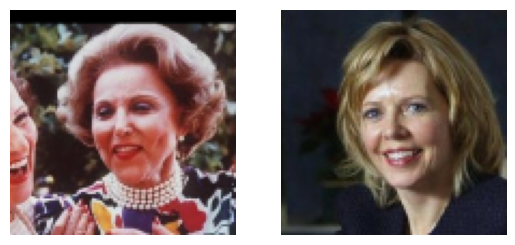

Prediction:  [0.03098289]


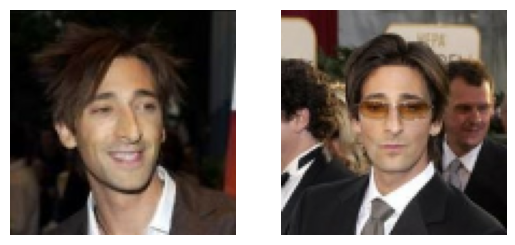

Prediction:  [0.8892092]


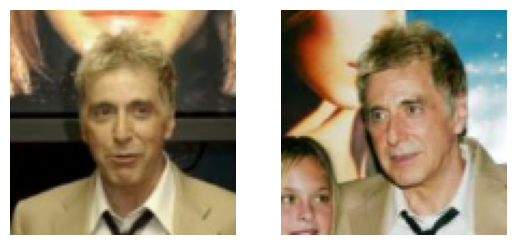

Prediction:  [0.99337876]


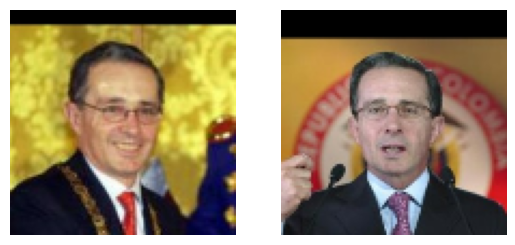

Prediction:  [0.99073696]


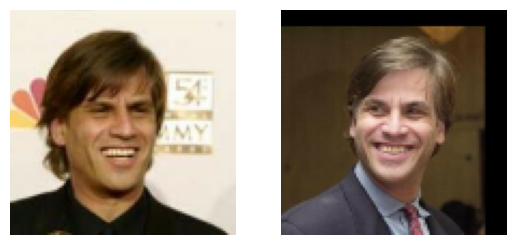

Prediction:  [0.9881991]


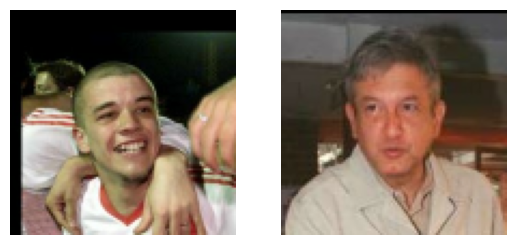

Prediction:  [0.00062541]


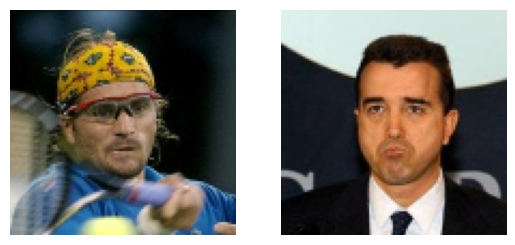

Prediction:  [7.683518e-05]


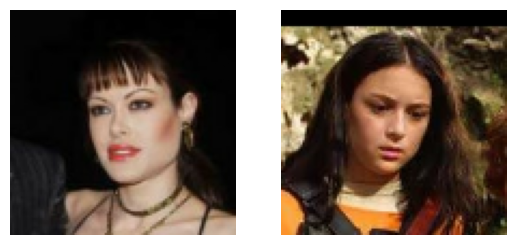

Prediction:  [0.00307397]


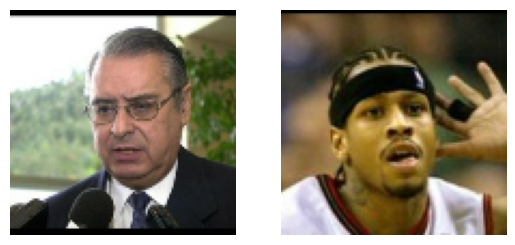

Prediction:  [0.00334448]


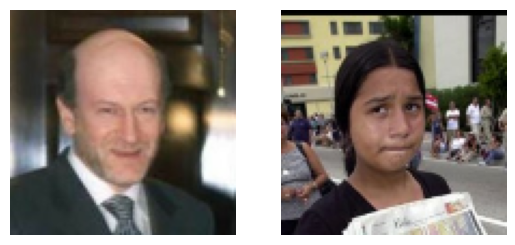

Prediction:  [0.00074311]


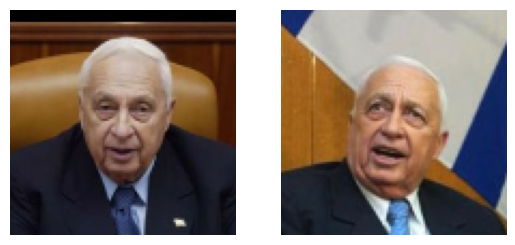

Prediction:  [0.97924143]


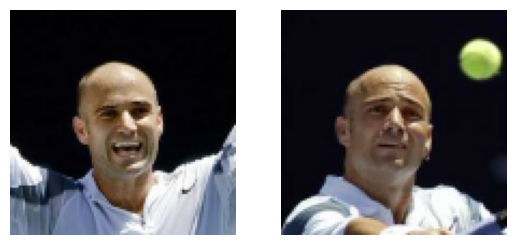

Prediction:  [0.99621785]


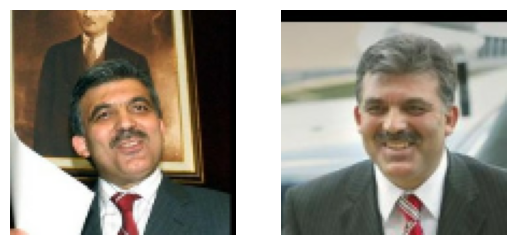

Prediction:  [0.99973595]


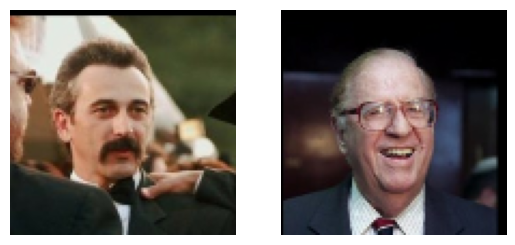

Prediction:  [0.00162565]


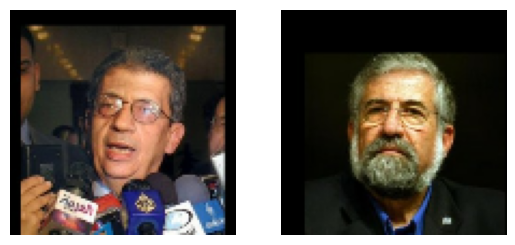

Prediction:  [0.00137899]


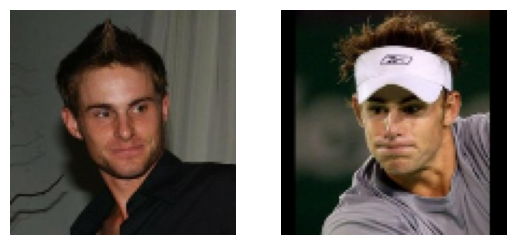

Prediction:  [0.99905276]


array([[3.0982895e-02],
       [8.8920921e-01],
       [9.9337876e-01],
       [9.9073696e-01],
       [9.8819911e-01],
       [6.2540692e-04],
       [7.6835182e-05],
       [3.0739696e-03],
       [3.3444799e-03],
       [7.4311171e-04],
       [9.7924143e-01],
       [9.9621785e-01],
       [9.9973595e-01],
       [1.6256527e-03],
       [1.3789947e-03],
       [9.9905276e-01]], dtype=float32)

In [55]:


predictions = siamese_model.predict([test_input, test_val])

for i in range(16):
    fig, im = plt.subplots(1, 2)
    im[0].imshow(test_input[i])
    im[0].axis("off")
    im[1].imshow(test_val[i])
    im[1].axis("off")
    plt.show()


# predictions[0]
print("Prediction: " , predictions[0])

In [36]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [38]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]

In [39]:
y_true

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int32)

#### Calculating Metrics

In [41]:
m= Recall()

In [42]:
m.update_state(y_true, y_hat)

In [43]:
m.result().numpy()

1.0

In [44]:
m = Precision()

In [45]:
m.update_state(y_true, y_hat)

In [46]:
m.result().numpy()

1.0

In [47]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 2s 2s/step
1.0 1.0


In [ ]:
saved_siamese_model = tf.keras.models.load_model('siamese_modelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})